# Experiment 02: Scattering + PCA + SVM






In [1]:
import sys
import random
sys.path.append('../src')
import warnings
warnings.filterwarnings("ignore") 

from utils.compute_metrics import get_metrics, get_majority_vote,log_test_metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from tqdm import tqdm
from pprint import pprint

from itertools import product
import pickle
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt


## Feature Reduction/Selection

#### Upload Scattering Features

In [4]:
with open('../data/03_features/scattering_features.pickle', 'rb') as handle:
    scatter_dict = pickle.load(handle)
    df_scattering = scatter_dict['df']
    scattering_params = {'J':scatter_dict['J'],
                         'M':scatter_dict['M'],
                         'N':scatter_dict['N']}

# Cross Validation using SVM Classification

> Methods that exclude outliers were used to normalize the features. Patient-specific leave-one-out cross-validation (LOOCV) was applied to evaluate the classification. In each case, the test set consisted of10 images from the same patient and the training set contained 540 images from the remaining 54 patients. For each training set, fivefold cross-validation and grid search were applied to indicate the optimal SVM classifier hyperparameters and the best kernel. To address the problem of class imbalance, the SVM hyperparameter C of each class was adjusted inversely proportional to that class frequency in the training set. Label 1 indicated the image containing a fatty liver and label −1 otherwise. 


In [5]:
# Set the parameters by cross-validation
param_gamma = [1e-3, 1e-4]
param_C = [1, 10, 1000] 
svm_class_weight = [None, 'balanced']
rbf_params = list(product(['kernel'],param_gamma, param_C, svm_class_weight ))
linear_params = list(product(['linear'],param_C, svm_class_weight))
params = rbf_params + linear_params

In [6]:
def train_valid(param, X_train,X_valid,y_train, y_valid, pca_n_components = 5):
    if param[0] == 'kernel': 
        #The “balanced” mode uses the values of y to automatically adjust weights inversely
        #proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
        model = SVC(gamma=param[1], C=param[2], class_weight= param[3])
    if param[0] == 'linear': 
        #The “balanced” mode uses the values of y to automatically adjust weights inversely
        #proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
        model = LinearSVC(C=param[1], class_weight= param[2])

    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    acc, auc, specificity, sensitivity = get_metrics(y_valid, predictions)
    return acc, auc, specificity, sensitivity , predictions


In [7]:
def log_val_metrics(params, metrics, test_n_splits):
    mlflow.set_experiment('val_scattering_svm_pca_experiment')
    # log mlflow params
    for param in params:
        with mlflow.start_run():
            #log params
            mlflow.log_param('pca_n',pca_n_components)
            mlflow.log_params(scattering_params)
            mlflow.log_param('model',f'svm: {param[0]}')
            mlflow.log_param('test K fold', test_n_splits)
            if param[0] == 'kernel':
                mlflow.log_param('gamma',param[1])
                mlflow.log_param('C',param[2])
                mlflow.log_param('class weight svm', param[3])
            if param[0] == 'linear': 
                mlflow.log_param('C',param[1])
                mlflow.log_param('class weight svm', param[2])
            #log metrics
            mlflow.log_metric('accuracy',np.array(metrics[str(param)]['acc']).mean())
            mlflow.log_metric('AUC',np.array(metrics[str(param)]['auc']).mean())
            mlflow.log_metric('specificity',np.array(metrics[str(param)]['specificity']).mean())
            mlflow.log_metric('sensitivity',np.array(metrics[str(param)]['sensitivity']).mean())
    print("Done logging validation params in MLFlow")

In [8]:
df = df_scattering
pca_n_components = 5
standardize = True
test_metrics={}  
#majority vote results
test_metrics_mv={}    
test_n_splits = 55
group_kfold_test = GroupKFold(n_splits=test_n_splits)
seed= 1111
df_pid = df['id']
df_y = df['class']
fold_c =1 

for train_index, test_index in group_kfold_test.split(df, 
                                                  df_y, 
                                                  df_pid):
    random.seed(seed)
    random.shuffle(train_index)
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
    X_test = X_test.drop(columns=['id', 'class'])
    X_train_pid = X_train.pop('id')
    X_train = X_train.drop(columns=['class'])
    
    # Do cross-validation for hyperparam tuning
    group_kfold_val = GroupKFold(n_splits=5)
    metrics={}
    #X_train_y = df.pop('class')
    for subtrain_index, valid_index in group_kfold_val.split(X_train, 
                                                      y_train, 
                                                      X_train_pid):
                                   
        X_subtrain, X_valid = X_train.iloc[subtrain_index], X_train.iloc[valid_index]
        y_subtrain, y_valid = y_train.iloc[subtrain_index], y_train.iloc[valid_index]

        pca = PCA(n_components=pca_n_components,random_state = seed)           
        X_subtrain = pca.fit_transform(X_subtrain)
        X_valid = pca.transform(X_valid)

        #standardize
        if standardize:
            scaler = StandardScaler()
            X_subtrain = scaler.fit_transform(X_subtrain)
            X_valid = scaler.transform(X_valid)

        for param in tqdm(params):
            if str(param) not in metrics.keys() :
                metrics[str(param)] ={'acc':[], 'auc':[], 'sensitivity':[], 'specificity':[]}
                                   
            acc, auc, specificity, sensitivity,_ = train_valid(param, X_subtrain,X_valid,y_subtrain, y_valid)
            metrics[str(param)]['auc'].append(auc)
            metrics[str(param)]['acc'].append(acc)
            metrics[str(param)]['sensitivity'].append(sensitivity)
            metrics[str(param)]['specificity'].append(specificity)
    #log validation metrics for all combination of params
    log_val_metrics(params, metrics, test_n_splits)
    
    #highest accuracy
    index_param_max = np.array([np.array(metrics[str(param)]['auc']).mean() for param in params]).argmax()
    print('From all the combinations, the highest accuracy was achieved with', params[index_param_max])
    #train and test with max param
    pca = PCA(n_components=pca_n_components)           
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    #standardize
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    acc, auc, specificity, sensitivity, predictions = train_valid(params[index_param_max], X_train, X_test, y_train, y_test)
    
    #compute majority vote metrics
    acc_mv, auc_mv, specificity_mv, sensitivity_mv = get_majority_vote(y_test, predictions)
    
    print('FOLD '+ str(fold_c) + ':  acc ' + str(acc) +  ', auc ' +  str(auc) +  ', specificity '+ str(specificity)
          + ', sensitivity ' + str(sensitivity))
    print('FOLD '+ str(fold_c) + ':  MV acc ' + str(acc_mv) +  ', MV auc ' +  str(auc_mv) +  ', MV specificity '+ str(specificity_mv)
          + ', MV sensitivity ' + str(sensitivity_mv))
    
    test_metrics[fold_c]=  {'acc':acc, 'auc':auc, 'sensitivity':sensitivity, 'specificity':specificity, 'param':params[index_param_max]}
    test_metrics_mv[fold_c]=  {'acc':acc_mv, 'auc':auc_mv, 'sensitivity':sensitivity_mv, 'specificity':specificity_mv, 'param':params[index_param_max]}
    
    fold_c +=1 

log_test_metrics(test_metrics, test_metrics_mv, test_n_splits, 'Scattering features + PCA + SVM',seed))


100%|██████████| 18/18 [00:00<00:00, 103.77it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 1:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 1:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 95.67it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 2:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 2:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 96.86it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 3:  acc 0.0, auc 0.0, specificity nan, sensitivity 0.0
FOLD 3:  MV acc 0.0, MV auc 0.0, MV specificity nan, MV sensitivity 0.0


100%|██████████| 18/18 [00:00<00:00, 88.33it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 4:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 4:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 93.10it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 5:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 5:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 102.78it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 1, 'balanced')
FOLD 6:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 6:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 85.40it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 7:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 7:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 85.04it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 8:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 8:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 96.78it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 9:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 9:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 92.29it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 10:  acc 0.0, auc 0.0, specificity nan, sensitivity 0.0
FOLD 10:  MV acc 0.0, MV auc 0.0, MV specificity nan, MV sensitivity 0.0


100%|██████████| 18/18 [00:00<00:00, 91.76it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 11:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 11:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 93.42it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 12:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 12:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 85.37it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 13:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 13:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 97.24it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 14:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 14:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 95.74it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 15:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 15:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 93.76it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 16:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 16:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 93.40it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 17:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 17:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 85.84it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 1000, 'balanced')
FOLD 18:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 18:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 95.26it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 19:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 19:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 95.33it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 20:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 20:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 102.42it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 1, 'balanced')
FOLD 21:  acc 0.0, auc 0.0, specificity 0.0, sensitivity nan
FOLD 21:  MV acc 0.0, MV auc 0.0, MV specificity 0.0, MV sensitivity nan


100%|██████████| 18/18 [00:00<00:00, 92.65it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 10, 'balanced')
FOLD 22:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 22:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 89.73it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 23:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 23:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 87.44it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 1, 'balanced')
FOLD 24:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 24:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 90.76it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 25:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 25:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 95.10it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('linear', 1, None)
FOLD 26:  acc 0.0, auc 0.0, specificity 0.0, sensitivity nan
FOLD 26:  MV acc 0.0, MV auc 0.0, MV specificity 0.0, MV sensitivity nan


100%|██████████| 18/18 [00:00<00:00, 93.49it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 27:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 27:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 89.89it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 28:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 28:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 86.26it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 29:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 29:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 100.41it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 30:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 30:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 102.59it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 31:  acc 0.0, auc 0.0, specificity nan, sensitivity 0.0
FOLD 31:  MV acc 0.0, MV auc 0.0, MV specificity nan, MV sensitivity 0.0


100%|██████████| 18/18 [00:00<00:00, 97.74it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('linear', 10, 'balanced')
FOLD 32:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 32:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 92.23it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 33:  acc 0.1, auc 0.1, specificity nan, sensitivity 0.1
FOLD 33:  MV acc 0.0, MV auc 0.0, MV specificity nan, MV sensitivity 0.0


100%|██████████| 18/18 [00:00<00:00, 96.74it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 34:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 34:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 97.71it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 35:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 35:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 100.50it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 36:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 36:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 101.39it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 1000, 'balanced')
FOLD 37:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 37:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 99.54it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 38:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 38:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 94.99it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 39:  acc 0.7, auc 0.7, specificity nan, sensitivity 0.7
FOLD 39:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 96.51it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 40:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 40:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 96.25it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 41:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 41:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 107.56it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('linear', 1000, None)
FOLD 42:  acc 0.0, auc 0.0, specificity nan, sensitivity 0.0
FOLD 42:  MV acc 0.0, MV auc 0.0, MV specificity nan, MV sensitivity 0.0


100%|██████████| 18/18 [00:00<00:00, 94.05it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 43:  acc 0.0, auc 0.0, specificity nan, sensitivity 0.0
FOLD 43:  MV acc 0.0, MV auc 0.0, MV specificity nan, MV sensitivity 0.0


100%|██████████| 18/18 [00:00<00:00, 94.39it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('linear', 1000, 'balanced')
FOLD 44:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 44:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 94.61it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 45:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 45:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 87.67it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 46:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 46:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 61.49it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 47:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 47:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 55.46it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 48:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 48:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 95.24it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 49:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 49:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 78.07it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 50:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 50:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 85.02it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 51:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 51:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 99.47it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 52:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 52:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 83.95it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, 'balanced')
FOLD 53:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 53:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 75.67it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 54:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 54:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:00<00:00, 80.17it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.0001, 1000, 'balanced')
FOLD 55:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 55:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0
nan nan
nan nan
Experiment done


In [11]:
mlflow.search_runs(experiment_ids=['2']).sort_values('start_time',ascending=False).filter(regex='Model|metrics|time')

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,start_time,end_time,metrics.accuracy variance,metrics.sensitivity mean,metrics.AUC mean,metrics.AUC variance,metrics.accuracy mean,metrics.specificity mean,metrics.sensitivity variance,metrics.specificity variance,params.Model
0,2020-10-14 02:36:41.279000+00:00,2020-10-14 02:36:42.752000+00:00,0.020496,0.901515,0.746212,0.057909,0.836364,0.590909,0.017447,0.219008,AVG Pooling Inception features + SVM
1,2020-10-14 02:36:39.499000+00:00,2020-10-14 02:36:41.175000+00:00,0.016833,0.890152,0.740530,0.050423,0.821818,0.590909,0.009985,0.171736,AVG Pooling Inception features + SVM
2,2020-10-14 02:33:27.796000+00:00,2020-10-14 02:33:29.903000+00:00,0.050909,0.901515,0.768939,0.074925,0.800000,0.636364,0.028811,0.191001,Pretrained Restnet-34 on ImageNet
3,2020-10-14 02:33:25.472000+00:00,2020-10-14 02:33:27.703000+00:00,0.029924,0.915152,0.784091,0.044220,0.821818,0.653030,0.014909,0.112062,Pretrained Restnet-34 on ImageNet
4,2020-10-14 02:26:30+00:00,2020-10-14 02:26:31.405000+00:00,0.111074,0.921053,0.872727,0.111074,0.872727,0.764706,0.072715,0.179931,AVG Pooling Inception features + SVM
5,2020-10-14 02:26:28.427000+00:00,2020-10-14 02:26:29.912000+00:00,0.090360,0.907895,0.838182,0.090360,0.838182,0.682353,0.048096,0.149689,AVG Pooling Inception features + SVM
6,2020-10-14 02:18:49.763000+00:00,2020-10-14 02:18:51.092000+00:00,0.111074,0.947368,0.872727,0.111074,0.872727,0.705882,0.049861,0.207612,Pretrained Restnet-34 on ImageNet
7,2020-10-14 02:18:48.335000+00:00,2020-10-14 02:18:49.672000+00:00,0.077474,0.950000,0.867273,0.077474,0.867273,0.682353,0.032500,0.128512,Pretrained Restnet-34 on ImageNet
8,2020-10-14 01:05:33.598000+00:00,2020-10-14 01:05:34.695000+00:00,0.148760,0.818182,0.818182,0.148760,0.818182,0.818182,0.148760,0.148760,Pretrained Restnet-34 on ImageNet
9,2020-10-14 01:05:32.465000+00:00,2020-10-14 01:05:33.520000+00:00,0.101369,NaN,0.816364,0.101369,0.816364,NaN,NaN,NaN,Pretrained Restnet-34 on ImageNet


# Analyzing PCA



In [7]:
df_train, df_test = train_test_split(df_scattering)
pca = PCA(n_components=50)           
data = pca.fit_transform(df_train)

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


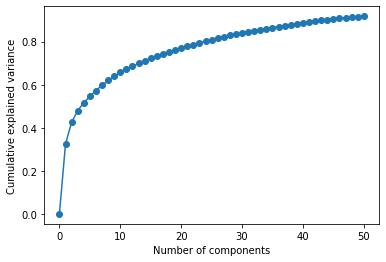

In [12]:
plt.plot(np.insert(pca.explained_variance_ratio_.cumsum(),0,0),marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [13]:
print(pca.explained_variance_ratio_.cumsum())

[0.32492575 0.42469525 0.4798019  0.51609635 0.5453536  0.57315236
 0.59722865 0.61983025 0.63891876 0.6568953  0.6721498  0.6857487
 0.69889057 0.71098614 0.7222507  0.73308104 0.74316007 0.7525093
 0.7614033  0.770065   0.7785104  0.78667223 0.79453176 0.8020777
 0.80899334 0.8156645  0.8221985  0.8286165  0.83461845 0.84031194
 0.8457946  0.8510881  0.85620195 0.86108404 0.865758   0.87031674
 0.8747754  0.8790858  0.8833129  0.88729066 0.89119375 0.89489025
 0.8983691  0.90175486 0.90500927 0.90807843 0.9110143  0.9137894
 0.9163307  0.9180361 ]
